In [1]:
import sys
import os
sys.path.append('..')

import pandas as pd
from sqlalchemy import create_engine
from decouple import config

import config as cfg

# Getting Data

In [2]:
user = config('DB_USER')
password = config('DB_PASSWORD')
host = config('DB_HOST')
port = config('DB_PORT')
name = config('DB_NAME')

df = pd.read_sql(
        'SELECT * FROM weather_schema.climate', 
        create_engine(
            f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{name}'
        )
    )
df.head()

,entryid,dateid,stationid,provinceid,mintemperature,maxtemperature,avgtemperature,avghumidity,rainfall,sunshinedirection,maxwindspeed,avgwindspeed,winddirection,mostwinddirection
0,20035011,20100101,96001,1,21.4,30.2,27.1,82.0,9.0,0.5,7.0,5.0,90.0,E
1,20035012,20100102,96001,1,21.0,29.6,25.7,95.0,24.0,0.2,6.0,4.0,90.0,E
2,20035013,20100103,96001,1,20.2,26.8,24.5,98.0,63.0,0.0,5.0,4.0,90.0,E
3,20035014,20100104,96001,1,21.0,29.2,25.8,90.0,0.0,0.1,4.0,3.0,225.0,SW
4,20035015,20100105,96001,1,21.2,30.0,26.7,90.0,2.0,0.4,NaN,NaN,NaN,


# Performing Clustering

In [3]:
# Prepare Dataset
df = df.drop(columns=['maxwindspeed', 'avgwindspeed', 'winddirection', 'mostwinddirection'])
df.dropna(inplace=True)
df.head()

,entryid,dateid,stationid,provinceid,mintemperature,maxtemperature,avgtemperature,avghumidity,rainfall,sunshinedirection
0,20035011,20100101,96001,1,21.4,30.2,27.1,82.0,9.0,0.5
1,20035012,20100102,96001,1,21.0,29.6,25.7,95.0,24.0,0.2
2,20035013,20100103,96001,1,20.2,26.8,24.5,98.0,63.0,0.0
3,20035014,20100104,96001,1,21.0,29.2,25.8,90.0,0.0,0.1
4,20035015,20100105,96001,1,21.2,30.0,26.7,90.0,2.0,0.4


In [4]:
# Smart Imputation
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383788 entries, 0 to 589264
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   entryid            383788 non-null  int64  
 1   dateid             383788 non-null  int64  
 2   stationid          383788 non-null  int64  
 3   provinceid         383788 non-null  int64  
 4   mintemperature     383788 non-null  float64
 5   maxtemperature     383788 non-null  float64
 6   avgtemperature     383788 non-null  float64
 7   avghumidity        383788 non-null  float64
 8   rainfall           383788 non-null  float64
 9   sunshinedirection  383788 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 32.2 MB


In [5]:
df = df.drop(columns=['entryid', 'dateid', 'stationid', 'provinceid'])

In [6]:
from sklearn.preprocessing import StandardScaler

preprocessors = []
for col in df.columns:
    preprocessor = StandardScaler()
    df[col] = preprocessor.fit_transform(df[col].values.reshape(-1, 1))
    preprocessors.append(preprocessor)
df.head()

,mintemperature,maxtemperature,avgtemperature,avghumidity,rainfall,sunshinedirection
0,-0.906948,-0.591248,0.147624,-0.074720,0.033609,-1.355712
1,-1.091447,-0.868449,-0.592958,1.162168,0.877959,-1.448788
2,-1.460447,-2.162055,-1.227742,1.447604,3.073271,-1.510838
3,-1.091447,-1.053250,-0.540059,0.686442,-0.473002,-1.479813
4,-0.999197,-0.683648,-0.063971,0.686442,-0.360422,-1.386737


In [7]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=6)
model.fit(df)
clusters = model.predict(df)

clusters

array([5, 5, 1, ..., 5, 0, 3])

# Performing Forecast

In [19]:
df = pd.read_sql(
        '''SELECT
            d.*,
            c.stationid,
            c.mintemperature,
            c.maxtemperature,
            c.avgtemperature,
            c.avghumidity,
            c.rainfall,
            c.sunshinedirection,
            c.maxwindspeed,
            c.avgwindspeed,
            c.winddirection,
            c.mostwinddirection,
            s.latitude,
            s.longitude
        FROM
            weather_schema.climate c
            LEFT JOIN weather_schema.dates d ON c.dateid = d.dateid\
            LEFT JOIN weather_schema.station s ON s.stationid = c.stationid
        ''',
        create_engine(
            f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{name}'
        )
    )
df['fulldate'] = pd.to_datetime(df['fulldate'], format='%Y-%m-%d')
df.head()

,dateid,fulldate,year,quarter,month,day,stationid,mintemperature,maxtemperature,avgtemperature,avghumidity,rainfall,sunshinedirection,maxwindspeed,avgwindspeed,winddirection,mostwinddirection,latitude,longitude
0,20100101,2010-01-01,2010,1,1,1,96001,21.4,30.2,27.1,82.0,9.0,0.5,7.0,5.0,90.0,E,5.87655,95.33785
1,20100102,2010-01-02,2010,1,1,2,96001,21.0,29.6,25.7,95.0,24.0,0.2,6.0,4.0,90.0,E,5.87655,95.33785
2,20100103,2010-01-03,2010,1,1,3,96001,20.2,26.8,24.5,98.0,63.0,0.0,5.0,4.0,90.0,E,5.87655,95.33785
3,20100104,2010-01-04,2010,1,1,4,96001,21.0,29.2,25.8,90.0,0.0,0.1,4.0,3.0,225.0,SW,5.87655,95.33785
4,20100105,2010-01-05,2010,1,1,5,96001,21.2,30.0,26.7,90.0,2.0,0.4,NaN,NaN,NaN,,5.87655,95.33785


In [20]:
df

,dateid,fulldate,year,quarter,month,day,stationid,mintemperature,maxtemperature,avgtemperature,avghumidity,rainfall,sunshinedirection,maxwindspeed,avgwindspeed,winddirection,mostwinddirection,latitude,longitude
0,20100101,2010-01-01,2010,1,1,1,96001,21.4,30.2,27.1,82.0,9.0,0.5,7.0,5.0,90.0,E,5.87655,95.33785
1,20100102,2010-01-02,2010,1,1,2,96001,21.0,29.6,25.7,95.0,24.0,0.2,6.0,4.0,90.0,E,5.87655,95.33785
2,20100103,2010-01-03,2010,1,1,3,96001,20.2,26.8,24.5,98.0,63.0,0.0,5.0,4.0,90.0,E,5.87655,95.33785
3,20100104,2010-01-04,2010,1,1,4,96001,21.0,29.2,25.8,90.0,0.0,0.1,4.0,3.0,225.0,SW,5.87655,95.33785
4,20100105,2010-01-05,2010,1,1,5,96001,21.2,30.0,26.7,90.0,2.0,0.4,NaN,NaN,NaN,,5.87655,95.33785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589260,20201227,2020-12-27,2020,5,12,27,97980,25.2,31.2,29.2,74.0,0.0,1.4,4.0,2.0,280.0,C,-8.52019,140.41568
589261,20201228,2020-12-28,2020,5,12,28,97980,25.3,31.6,28.1,78.0,NaN,3.0,12.0,2.0,260.0,C,-8.52019,140.41568
589262,20201229,2020-12-29,2020,5,12,29,97980,24.6,32.3,28.4,81.0,NaN,6.5,5.0,2.0,260.0,SW,-8.52019,140.41568
589263,20201230,2020-12-30,2020,5,12,30,97980,25.2,32.6,28.4,80.0,0.0,2.4,7.0,2.0,260.0,C,-8.52019,140.41568


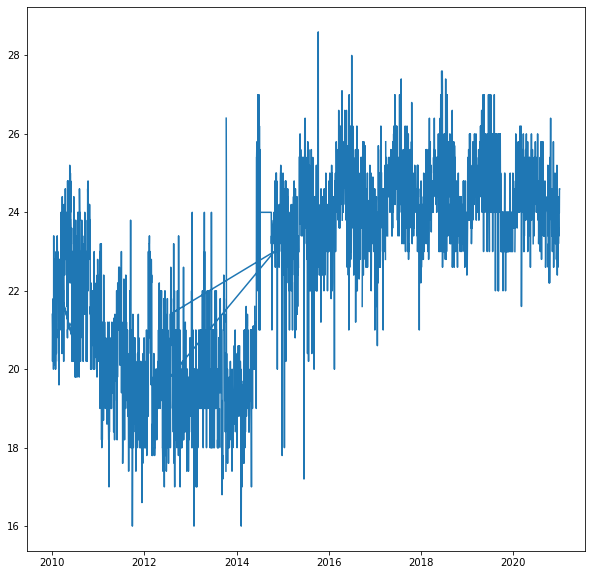

In [24]:
# Visualize Time Series
import matplotlib.pyplot as plt
temp_df = df.copy()
temp_df = temp_df[(temp_df['stationid'] == 96001)]

plt.figure(figsize=(10, 10))
plt.plot(temp_df['fulldate'], temp_df['mintemperature'])
plt.show()

# Transform Data into Regression Problem